In [1]:
import sys
sys.path.append('../')

In [26]:
# Load events from nEXO MC files:

from nEXO_loader import loader

nexo_loader = loader()
#nexo_loader.filename = '/Users/yumiao/Documents/Works/0nbb/nEXO/offline-samples/bb0n_withPCDs/Baseline2019_bb0n_X0Y0Z-400mm_seed223_comsol.nEXOevents.root'
nexo_loader.filename = '/Users/yumiao/Documents/Works/0nbb/nEXO/offline-samples/Baseline2019_bb0n_FullLXe_seed52_comsol.nEXOevents.root'
nexo_loader.load_nentries = 10
nexo_loader._load_event()

evtid = 0
one_event = nexo_loader._get_one_event(evtid)

print(one_event.keys())

['SimEvent', 'SimEvent/nEXO::EventObject', 'SimEvent/nEXO::EventObject/TObject', 'SimEvent/nEXO::EventObject/TObject/fUniqueID', 'SimEvent/nEXO::EventObject/TObject/fBits', 'SimEvent/fGenTheta_p', 'SimEvent/fGenPhi_p', 'SimEvent/fGenE', 'SimEvent/fParentTrackID', 'SimEvent/fNeutronCount', 'SimEvent/fXe137Count', 'SimEvent/fInitNeutronEnergy', 'SimEvent/fPMT_Hits', 'SimEvent/fPMTID', 'SimEvent/fPMTs_fired', 'SimEvent/fmu_Impact_parameter', 'SimEvent/fn_Impact_parameter', 'SimEvent/fTotalEventEnergy_WT', 'SimEvent/fEnergyDeposit_WT', 'SimEvent/fLengthDeposit_WT', 'SimEvent/fNumDeposits_WT', 'SimEvent/fEventNumber', 'SimEvent/fGenX', 'SimEvent/fGenY', 'SimEvent/fGenZ', 'SimEvent/fGenParticleID', 'SimEvent/fGenKineticE', 'SimEvent/fTotalEventEnergy', 'SimEvent/fNumDeposits', 'SimEvent/fLengthDeposit', 'SimEvent/fEnergyDeposit', 'SimEvent/fPreEnergyDeposit', 'SimEvent/fPostEnergyDeposit', 'SimEvent/fTrackNumber', 'SimEvent/fXpos', 'SimEvent/fYpos', 'SimEvent/fZpos', 'SimEvent/fTglob', 'SimE

In [27]:
rel_X_ystrip, rel_Y_ystrip, rel_Z_ystrip = [], [], []
rel_X_xstrip, rel_Y_xstrip, rel_Z_xstrip = [], [], []
anode_z = -402.97

print(f'>> Number of deposit points is {len(one_event["event_x"])}.')
print(f'>> Number of fired channel w/o cut is {len(one_event["xpos"])}.')

# brief cuts on deposit points, only keep those which deposit energy fraction larger than 1% of the total?
deposit_X = one_event['event_x']
deposit_Y = one_event['event_y']
deposit_Z = one_event['event_z']
deposit_E = one_event['event_E']

import numpy as np
ratio = 0.01 # -> A simple cut from my head at the moment...
deposit_X_filtered = deposit_X[deposit_E > ratio*np.sum(deposit_E)]
deposit_Y_filtered = deposit_Y[deposit_E > ratio*np.sum(deposit_E)]
deposit_Z_filtered = deposit_Z[deposit_E > ratio*np.sum(deposit_E)]
deposit_E_filtered = deposit_E[deposit_E > ratio*np.sum(deposit_E)]
print(f'>> Number of filtered deposit points is {len(deposit_E_filtered)}.')


for x_dep, y_dep, z_dep in zip(one_event['event_x'], one_event['event_y'], one_event['event_z']):
    for x_cha, y_cha, locid, charge in zip(one_event['xpos'], one_event['ypos'], one_event['localid'], one_event['q']):
        # charge cut:
        if charge != 0 and charge < 600:
            continue
        relX, relY, relZ = x_dep - x_cha, y_dep - y_cha, anode_z - z_dep
        if locid < 16:
            rel_X_xstrip.append(relX)
            rel_Y_xstrip.append(relY)
            rel_Z_xstrip.append(relZ)
        else:
            rel_X_ystrip.append(relX)
            rel_Y_ystrip.append(relY)
            rel_Z_ystrip.append(relZ)

print(f'>>> Avergae drift distance is {np.mean(rel_Z_xstrip)} +- {np.std(rel_Z_xstrip)} mm.')

>> Number of deposit points is 87.
>> Number of fired channel w/o cut is 37.
>> Number of filtered deposit points is 19.
>>> Avergae drift distance is 689.9508189884192 +- 2.0742966015664193 mm.


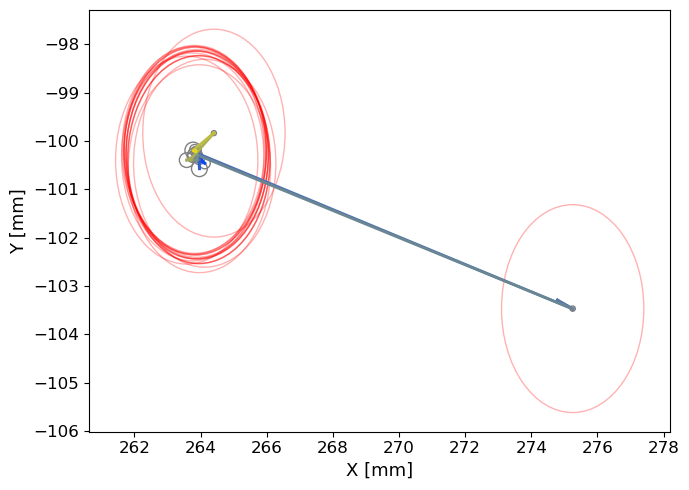

In [28]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(7, 5))

def hex_to_RGB(hex_str):
    """ #FFFFFF -> [255,255,255]"""
    #Pass 16 to the integer function for change of base
    return [int(hex_str[i:i+2], 16) for i in range(1,6,2)]

def get_color_gradient(c1, c2, n):
    assert n > 1
    c1_rgb = np.array(hex_to_RGB(c1))/255
    c2_rgb = np.array(hex_to_RGB(c2))/255
    mix_pcts = [x/(n-1) for x in range(n)]
    rgb_colors = [((1-mix)*c1_rgb + (mix*c2_rgb)) for mix in mix_pcts]
    return ["#" + "".join([format(int(round(val*255)), "02x") for val in item]) for item in rgb_colors]

colorlist = get_color_gradient("#0B46F1", "#E7D81A", len(deposit_X)-1)
#colorlist = get_color_gradient("#8A5AC2", "#3575D5", len(deposit_X)-1)

for i in range(len(deposit_X)-1):
    ax.plot(deposit_X[i:i+2], deposit_Y[i:i+2], '-', lw=2, color=colorlist[i])


ax.scatter(deposit_X_filtered, deposit_Y_filtered, s=deposit_E_filtered*500, fc='none', ec='gray')
sigmaD = np.mean(rel_Z_xstrip) / 1.7 * 0.0053
for x, y in zip(deposit_X_filtered, deposit_Y_filtered):
    cr = plt.Circle((x, y), sigmaD, color='red', alpha=0.3, fc='none')
    ax.add_patch(cr)

ax.set_xlabel('X [mm]', fontsize=13)
ax.set_ylabel('Y [mm]', fontsize=13)
ax.tick_params(axis='both', labelsize=12)
#ax.set_xlim(-2, 2)
#ax.set_ylim(-2, 2)
plt.tight_layout()
#plt.savefig('../../../my_notes_slides/figures/nEXOoffline_bb0nDeposit+track_1sigmaDiff.pdf')

In [22]:
# manual diffusion based on the energy deposition points:
import numpy as np
sigma_D = 1.4 # mm in this drift distance.
def f(x, y, x0, y0):
    return 1 / (2*np.pi*sigma_D**2) * np.exp(-0.5*(((x-x0)/sigma_D)**2+((y-y0)/sigma_D)**2))




In [6]:
# 2D gaussian fitting:
import numpy as np
def f(x, y):
    sigma_D = 2.0
    x0, y0 = 0, 0
    return 1 / (2*np.pi*sigma_D**2) * np.exp(-0.5*(((x-x0)/sigma_D)**2+((y-y0)/sigma_D)**2))


from scipy.integrate import dblquad, quad
sigma_D = 2.0
I0 = dblquad(lambda y, x: f(x, y), -100, 100, -100, 100)[0]
R = sigma_D * np.sqrt(2)
I1 = dblquad(lambda y, x: f(x, y), -R, R, -R, R )[0]
print(I0, I1)


# One-dimensional gaussian

def f1(x):
    return 1/(np.sqrt(2*np.pi)*sigma_D) * np.exp(-(x)**2/sigma_D**2/2)

v0 = quad(f1, -100, 100)[0]
v1 = quad(f1, -sigma_D, sigma_D)[0]
print(v0, v1)


0.9999999999988178 0.7101446264380783
1.0000000000000002 0.682689492137086
